# Marble Defect Classifier
- This application of detecting defect on metal surface is an example of how deep learning can be implemented to Industrial Processes. 
- It will reduce the inprocess error and add a middle layer to quality inspection.
- image dimension 256x256
- There are four classes of deformations.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing necessary libraries :

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras as ks
import os
import cv2

# Loading data :

In [3]:
train_dir = "/content/drive/MyDrive/marble defect/dataset/train/"
test_dir = "/content/drive/MyDrive/marble defect/dataset/test/"

In [4]:
def get_image(path):
    img = cv2.imread(path)
    print(img.shape)
    plt.imshow(img)

In [5]:
image = "/content/drive/MyDrive/marble defect/dataset/train/crack/_0_0_20210531_17292.jpg"

(256, 256, 3)


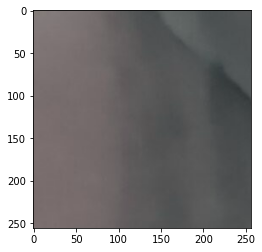

In [6]:
get_image(image)

## Create Image Data Generator

In [7]:
def datapreprocessing(main_dir,bsize):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
    train_gen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   shear_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   #validation_split=0.3,
                                   fill_mode='nearest',
                                  )

    train_generator = train_gen.flow_from_directory(
        directory=main_dir,
        target_size=(48,48),
        batch_size=bsize,
        color_mode="rgb",
        shuffle=True,
        subset="training",
        class_mode='categorical')
    
    
    
    return train_generator

In [8]:
traingen = datapreprocessing(train_dir,20)
validgen = datapreprocessing(test_dir,20)

Found 2249 images belonging to 4 classes.
Found 688 images belonging to 4 classes.


In [9]:
labelnames = traingen.class_indices
labelnames

{'crack': 0, 'dot': 1, 'good': 2, 'joint': 3}

In [10]:
#Function that can build a dataframe on passing folderpath.
def getdata(folder_path):
    sig = pd.DataFrame(columns=['image_abs_path','image_labels'])
    for key,value in labelnames.items():
        #print("processing for label: {}".format(label))
        label_i = folder_path+"/"+str(key)
        #read directory
        dirs_label_i =  os.listdir(label_i)
        idx = 0
        for image in dirs_label_i:
            #create a absolute image path
            sig_i = os.path.join(label_i,image)
            #print('Absolute path for image no. {} and label {}: {}'\
                  #.format(idx,label,flower_i))

            #fill the dataframe with path and label
            sig = sig.append({'image_abs_path':sig_i,
                            'image_labels':key},
                           ignore_index=True)
            idx += 1
    return sig

In [11]:
#Create Train Dataframe as repository of paths and labels.
valid = getdata(test_dir)

In [12]:
valid

,image_abs_path,image_labels
0,/content/drive/MyDrive/marble defect/dataset/t...,crack
1,/content/drive/MyDrive/marble defect/dataset/t...,crack
2,/content/drive/MyDrive/marble defect/dataset/t...,crack
3,/content/drive/MyDrive/marble defect/dataset/t...,crack
4,/content/drive/MyDrive/marble defect/dataset/t...,crack
...,...,...
683,/content/drive/MyDrive/marble defect/dataset/t...,joint
684,/content/drive/MyDrive/marble defect/dataset/t...,joint
685,/content/drive/MyDrive/marble defect/dataset/t...,joint
686,/content/drive/MyDrive/marble defect/dataset/t...,joint


In [13]:
# Fetch n number of images from train data frame
def get_n_images(n,df,label):
    import warnings
    warnings.filterwarnings('ignore')
    train = df[df["image_labels"]==label]
    print(len(train))
    i = 0
    m = n/2
    plt.figure(figsize=(12, 6))
    for path in train['image_abs_path'][0:n]:
        plt.subplot(2,m,i+1)
        get_image(path)
        #plt.title(train['image_labels'][i])
        i += 1
    plt.tight_layout()
    plt.show()

In [14]:
def visualize_gen(train_generator):   
    #Visualising Images Processed
    plt.figure(figsize=(6, 3))
    for i in range(0, 10):
        plt.subplot(2, 5, i+1)
        for X_batch, Y_batch in train_generator:
            image = X_batch[0]        
            plt.axis("off")
            plt.imshow((image*255).astype(np.uint8))
            break
    plt.tight_layout()
    plt.show()

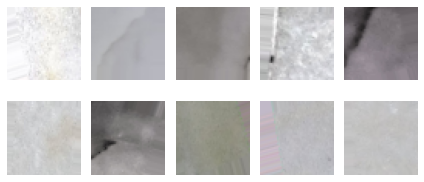

In [15]:
visualize_gen(traingen)

In [16]:
input_shape = traingen.image_shape
input_shape

(48, 48, 3)

## Build Model's Architecture

In [17]:
def imageclf2(input_shape):
    from tensorflow import keras as ks
    #from tensorflow.keras import regularizers
    model = ks.models.Sequential()
    #building architecture
    #Adding layers
    model.add(ks.layers.Conv2D(8,(3,3),
                               strides=1,
                               activation="relu",
                               padding='same',
                               name="layer1",
                               input_shape=input_shape))
    model.add(ks.layers.MaxPooling2D(pool_size=2,strides=2))
    model.add(ks.layers.Dropout(0.2))
    model.add(ks.layers.Conv2D(8,(3,3),strides=1,padding="same",activation="relu",name="layer2"))
    model.add(ks.layers.MaxPooling2D(pool_size=2,strides=2))

    
    model.add(ks.layers.Flatten())
    model.add(ks.layers.Dense(128,activation="relu",
                              name="layer5"))
    model.add(ks.layers.Dropout(0.2))
    
    model.add(ks.layers.Dense(4,activation="softmax",
                              name="output"))
    model.summary()
    
    return model


## Build the Compiler

In [18]:
def compiler2(model,train_generator,valid_generator,epchs,bsize=32,lr=0.0001):

    from tensorflow import keras as ks
    callbck = ks.callbacks.EarlyStopping(monitor='val_loss',patience=10,
                                         verbose=2,
                                         restore_best_weights=True,) 
    
    opt = ks.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss="categorical_crossentropy",
                      optimizer=opt,
                      metrics=["accuracy"])
    history = model.fit(train_generator,
                        epochs=epchs,
                        callbacks=[callbck],
                        validation_data=valid_generator,
                        verbose = 1,
                        #steps_per_epoch = train_generator.n // bsize
                       )
    #Visualise curves
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='valid_acc')

    plt.title('lrate='+str(lr), pad=-50)
    plt.legend()
    plt.grid(True)
    return model,history

### Fit Model and Evaluate

In [19]:
model01 = imageclf2(input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Conv2D)             (None, 48, 48, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 8)         0         
                                                                 
 layer2 (Conv2D)             (None, 24, 24, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1152)              0

Epoch 1/100
113/113 [==============================] - 782s 7s/step - loss: 1.2056 - accuracy: 0.4006 - val_loss: 1.1305 - val_accuracy: 0.4985
Epoch 2/100
113/113 [==============================] - 13s 112ms/step - loss: 1.1840 - accuracy: 0.4082 - val_loss: 1.1638 - val_accuracy: 0.3110
Epoch 3/100
113/113 [==============================] - 13s 116ms/step - loss: 1.1712 - accuracy: 0.4340 - val_loss: 1.1372 - val_accuracy: 0.4971
Epoch 4/100
113/113 [==============================] - 13s 115ms/step - loss: 1.1695 - accuracy: 0.4184 - val_loss: 1.1533 - val_accuracy: 0.5567
Epoch 5/100
113/113 [==============================] - 13s 114ms/step - loss: 1.1628 - accuracy: 0.4304 - val_loss: 1.1429 - val_accuracy: 0.5145
Epoch 6/100
113/113 [==============================] - 13s 114ms/step - loss: 1.1543 - accuracy: 0.4540 - val_loss: 1.1662 - val_accuracy: 0.4985
Epoch 7/100
113/113 [==============================] - 13s 113ms/step - loss: 1.1523 - accuracy: 0.4615 - val_loss: 1.1475 - v

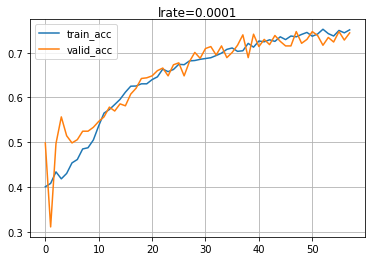

In [20]:
model_com01 = compiler2(model01,traingen,validgen,100)

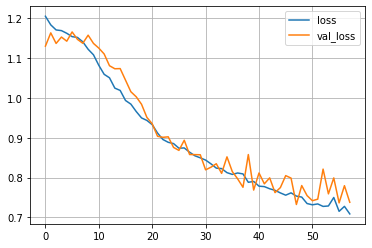

In [21]:
#Visualise loss curves
history = model_com01[1]
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()

### Get Prediction and visualise the output.

In [24]:
def get_predictions(n):
    import keras as ks
    image1= validgen[0][0][n]
    #print(image1.shape)
    plt.imshow(image1)
    input_arr = ks.preprocessing.image.img_to_array(validgen[0][0][n])
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    predict_x = model_com01[0].predict(input_arr)
    predictions = np.argmax(predict_x,axis=1)
    #our dictionary starts from 1 whereas model has classes from 0.
    return predictions

array([2])

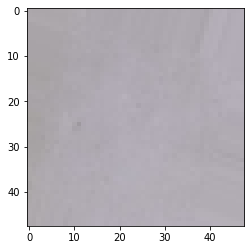

In [25]:
get_predictions(11)

In [26]:
# Fetch n number of images from train data frame
def get_n_images(n,df,label):
    import warnings
    warnings.filterwarnings('ignore')
    train = df[df["image_labels"]==label]
    print(len(train))
    i = 0
    m = n/2
    plt.figure(figsize=(12, 6))
    for path in train['image_abs_path'][0:n]:
        plt.subplot(2,m,i+1)
        get_image(path)
        #plt.title(train['image_labels'][i])
        i += 1
    plt.tight_layout()
    plt.show()

246
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


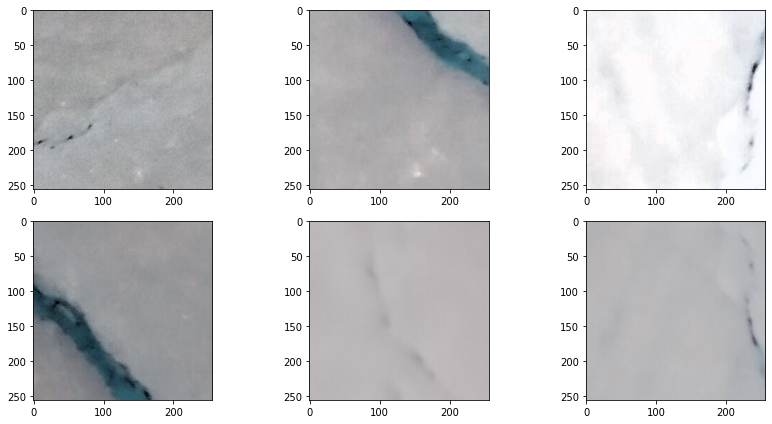

In [27]:
#Visualise Predictions
get_n_images(6,valid,"crack")

- Model has predicted the deformation correctly

## Save the model!

In [28]:
# save the model to disk
model = model_com01[0]
model.save('/content/drive/MyDrive/marble defect/MarbleModel.h5')